## Import

In [12]:
import pandas as pd
from warnings import simplefilter

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
from scipy.optimize import curve_fit
import numpy as np
import statsmodels.api as sm
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
from IPython.display import clear_output
from statsmodels.stats.outliers_influence import variance_inflation_factor

# from reload_recursive import reload_recursive
from statsmodels.stats.mediation import Mediation
from statsmodels.genmod.families import Poisson

from mri_data import file_manager as fm

In [ ]:
# reload_recursive(helpers)

## Load Data

### Clinical and Volumes

In [9]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/choroid_associations"
)

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
)
ventricle_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/paper1/data0/ventricle_volumes.csv",
    index_col="subid",
)

tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

csf_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/data0/csf_volumes.csv",
    index_col="subid",
)
third_ventricle_width = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/data0/third_ventricle_width.csv",
    index_col="subid",
)

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid"
)
df = df.join([choroid_volumes, tiv, ventricle_volumes, sdmt["SDMT"]])
df["SDMT"] = pd.to_numeric(df["SDMT"], errors="coerce")
df["thalamus_sqrt"] = np.sqrt(df["thalamus"])
df["thalamus_curt"] = np.sqrt(df["thalamus"] ** 3)
df["cortical_thickness_inv"] = 1 / df["cortical_thickness"]
df["ventricle_logtrans"] = np.log(df["ventricle_volume"])

df["allCSF"] = csf_volumes["all"]
df["thirdV"] = csf_volumes["third_ventricle"]
#! need to fix the actual segmentation files
df["periCSF"] = csf_volumes["peripheral"] - df["thirdV"]

df["thirdV_width"] = third_ventricle_width["third_ventricle_width"]
df["periCSF_frac"] = csf_volumes["peripheral"] / csf_volumes["all"]


df_z = df.copy()
numeric_cols = df.select_dtypes(include="number").columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

viridis = colormaps["viridis"].resampled(20)

colors = helpers.get_colors()

### HIPS-THOMAS Volumes and Distances

In [5]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_norm = df_thomas.apply(lambda col: col / df_thomas["THALAMUS_1"])
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")

df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_left_z = df_thomas_left.apply(stats.zscore, nan_policy="omit")

df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")
df_thomas_right = df_thomas_right.rename(columns=new_colnames)
df_thomas_right_z = df_thomas_right.apply(stats.zscore, nan_policy="omit")


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]

ignore_structs1 = [
    "THALAMUS_1",
    "Amy_34",
    "GP_33",
    "Cla_28",
    "Acc_26",
    "Hb_13",
    "MTT_14",
]
ignore_structs2 = ["THALAMUS_1", "Amy_34", "GP_33", "Hb_13", "MTT_14"]

thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)["index"]

mni_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_centroid_centroid_dists.csv",
    index_col="index",
)
mni_dists["struct"] = hips_thomas_ref

# mni_dists2 = pd.read_csv(
#     "/home/srs-9/Projects/ms_mri/data/mni_choroid_struct_SDT.csv",
#     index_col="index",
# )
# mni_dists2["struct"] = hips_thomas_ref

mni_ventricle_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_ventricle_centroid_centroid_dists.csv",
    index_col="index",
)
mni_ventricle_dists["struct"] = hips_thomas_ref


def combine_nuclei(df):
    df2 = pd.DataFrame()
    df2["anterior"] = df["AV_2"]
    df2["ventral"] = df["VA_4"] + df["VLa_5"] + df["VLP_6"] + df["VPL_7"]
    df2["intralaminar"] = df["CM_11"]
    df2["medial"] = df["MD_Pf_12"]
    df2["posterior"] = df["Pul_8"] + df["LGN_9"] + df["MGN_10"]
    df2["THALAMUS_1"] = df["THALAMUS_1"]
    return df2


def combine_nuclei2(df):
    df2 = pd.DataFrame()
    df2["anterior"] = df["AV_2"]
    df2["ventral"] = df["VA_4"] + df["VLa_5"] + df["VLP_6"] + df["VPL_7"]
    df2["medial"] = df["MD_Pf_12"] + df["CM_11"]
    df2["posterior"] = df["Pul_8"] + df["LGN_9"] + df["MGN_10"]
    df2["THALAMUS_1"] = df["THALAMUS_1"]
    return df2


mni_combined_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_combined_nuclei_centroid_centroid_dists.csv",
    index_col="index",
)

df_thomas2 = combine_nuclei2(df_thomas)
grouped_nuclei = df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]
df_thomas2_z = df_thomas2.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm = df_thomas2.apply(lambda col: col / df_thomas["THALAMUS_1"])
df_thomas2_norm_z = df_thomas2_norm.apply(stats.zscore, nan_policy="omit")

df_thomas2_left = combine_nuclei2(df_thomas_left)
df_thomas2_left_z = df_thomas2_left.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_left = df_thomas2.apply(lambda col: col / df_thomas["THALAMUS_1"])
df_thomas2_norm_left_z = df_thomas2_norm_left.apply(stats.zscore, nan_policy="omit")

df_thomas2_right = combine_nuclei2(df_thomas_right)
df_thomas2_right_z = df_thomas2_right.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_right = df_thomas2.apply(lambda col: col / df_thomas["THALAMUS_1"])
df_thomas2_norm_right_z = df_thomas2_norm_right.apply(stats.zscore, nan_policy="omit")

/home/srs-9/.virtualenvs/ms_mri/lib/python3.13/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
/home/srs-9/.virtualenvs/ms_mri/lib/python3.13/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
/home/srs-9/.virtualenvs/ms_mri/lib/python3.13/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
/home/srs-9/.virtualenvs/ms_mri/lib/python3.13/site-packag

In [6]:
hips_thomas_ref

index
1     THALAMUS_1
2           AV_2
4           VA_4
5          VLa_5
6          VLP_6
7          VPL_7
8          Pul_8
9          LGN_9
10        MGN_10
11         CM_11
12      MD_Pf_12
13         Hb_13
14        MTT_14
26        Acc_26
27        Cau_27
28        Cla_28
29        GPe_29
30        GPi_30
31        Put_31
32         RN_32
33         GP_33
34        Amy_34
Name: struct, dtype: object

## Functions

### Old Functions

In [7]:
def regress_all_nuclei(model_data, covariates, outcome, structs):
    pvals = {}
    coefs = {}
    se = {}

    if len(covariates) > 0:
        plus_covariates = f"+ {covariates}"
    else:
        plus_covariates = ""
    all_results = {}
    for struct in structs:
        formula = f"{outcome} ~ {struct}*dzdur*dz_type5 {plus_covariates}"
        res = sm.OLS.from_formula(formula, data=model_data).fit()
        pvals[struct] = res.pvalues[struct]
        coefs[struct] = res.params[struct]
        se[struct] = res.HC0_se[struct]
        all_results[struct] = res

    regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals, "se": se})
    regression_results["p_fdr"] = stats.false_discovery_control(
        regression_results["pvals"], method="bh"
    )
    # regression_results = regression_results.sort_values(by="coef", ascending=True)
    regression_results.insert(0, "struct", regression_results.index)
    new_index = []
    for item in regression_results.struct:
        new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

    for i, row in regression_results.iterrows():
        if row["p_fdr"] < 0.05:
            regression_results.loc[i, "coef_sig"] = row["coef"]
        else:
            regression_results.loc[i, "coef_sig"] = 0

    regression_results.index = new_index
    return regression_results


# make covariates a keyword arg
def run_regressions(model_data, covariates, pred, outcomes):
    pvals = {}
    coefs = {}
    se = {}
    llci = {}
    ulci = {}
    ci_str = {}
    r2 = {}

    if len(covariates) > 0:
        plus_covariates = f"+ {covariates}"
    else:
        plus_covariates = ""
    all_results = {}
    for outcome in outcomes:
        formula = f"{outcome} ~ {pred} {plus_covariates}"
        res = sm.OLS.from_formula(formula, data=model_data).fit()
        pvals[outcome] = res.pvalues[pred]
        coefs[outcome] = res.params[pred]
        se[outcome] = res.HC0_se[pred]
        all_results[outcome] = res
        ci = res.conf_int()
        llci[outcome] = ci.loc[pred, 0]
        ulci[outcome] = ci.loc[pred, 1]
        ci_str[outcome] = f"[{llci[outcome]:.6f}, {ulci[outcome]:.6f}]"
        r2[outcome] = res.rsquared_adj

    regression_results = pd.DataFrame(
        {
            "coef": coefs,
            "pvals": pvals,
            "se": se,
            "llci": llci,
            "ulci": ulci,
            "ci": ci_str,
        }
    )
    regression_results["p_fdr"] = stats.false_discovery_control(
        regression_results["pvals"], method="bh"
    )
    regression_results["R2"] = r2

    # regression_results = regression_results.sort_values(by="coef", ascending=True)

    for i, row in regression_results.iterrows():
        if row["p_fdr"] < 0.05:
            regression_results.loc[i, "coef_sig"] = row["coef"]
        else:
            regression_results.loc[i, "coef_sig"] = 0

    return regression_results


# make covariates a keyword arg
def run_regressions2(model_data, covariates, outcome, predictors):
    pvals = {}
    coefs = {}
    se = {}
    llci = {}
    ulci = {}
    ci_str = {}
    r2 = {}

    if len(covariates) > 0:
        plus_covariates = f"+ {covariates}"
    else:
        plus_covariates = ""
    all_results = {}
    for pred in predictors:
        formula = f"{outcome} ~ {pred} {plus_covariates}"
        res = sm.OLS.from_formula(formula, data=model_data).fit()
        pvals[pred] = res.pvalues[pred]
        coefs[pred] = res.params[pred]
        se[pred] = res.HC0_se[pred]
        all_results[pred] = res
        ci = res.conf_int()
        llci[pred] = ci.loc[pred, 0]
        ulci[pred] = ci.loc[pred, 1]
        ci_str[pred] = f"[{llci[pred]:.6f}, {ulci[pred]:.6f}]"
        r2[pred] = res.rsquared_adj

    regression_results = pd.DataFrame(
        {
            "coef": coefs,
            "pvals": pvals,
            "se": se,
            "llci": llci,
            "ulci": ulci,
            "ci": ci_str,
        }
    )
    regression_results["p_fdr"] = stats.false_discovery_control(
        regression_results["pvals"], method="bh"
    )
    regression_results["R2"] = r2

    # regression_results = regression_results.sort_values(by="coef", ascending=True)

    for i, row in regression_results.iterrows():
        if row["p_fdr"] < 0.05:
            regression_results.loc[i, "coef_sig"] = row["coef"]
        else:
            regression_results.loc[i, "coef_sig"] = 0

    return regression_results


def fix_hipsthomas_regression_results(regression_results: pd.DataFrame):
    regression_results.insert(0, "outcome", regression_results.index)
    new_index = []
    for item in regression_results.index:
        new_index.append(int(re.match(r".+_(\d+)$", item)[1]))
    regression_results.index = new_index
    regression_results.rename(columns={"outcome": "struct"}, inplace=True)
    return regression_results


def scatter_hist(
    x, y, ax, ax_histx, ax_histy, nbins=10, light_color=None, dark_color=None
):
    if light_color is None:
        light_color = "#1f77b4"
    if dark_color is None:
        dark_color = "#1f77b4"

    # make axes look nice
    ax_histx.set_axis_off()
    ax_histy.set_axis_off()
    ax.xaxis.set_ticks_position("both")
    ax.yaxis.set_ticks_position("both")

    # the scatter plot:
    ax.scatter(x, y, color=dark_color)
    ylim = ax.get_ylim()

    # the histograms
    xbins = np.linspace(np.min(x), np.max(x), nbins)
    ybins = np.linspace(np.min(y), np.max(y), nbins)
    ax_histx.hist(x, bins=xbins, color="gray", density=True)
    ax_histy.hist(
        y, bins=ybins, orientation="horizontal", color=light_color, density=True
    )

    # kde to plot on histograms
    densityx = stats.gaussian_kde(x.dropna())
    densityy = stats.gaussian_kde(y.dropna())
    xx = np.linspace(np.min(x), np.max(x), 50)
    xy = np.linspace(np.min(y), np.max(y), 50)
    ax_histx.plot(xx, densityx(xx), color="black")
    ax_histy.plot(densityy(xy), xy, color=dark_color)

    ax_histy.set_ylim(ylim)


def plot_regression(
    data,
    predictor,
    outcome,
    covariates,
    xlabel=None,
    ylabel=None,
    title=None,
    color="blue1",
):
    plus_covariates = ""
    if len(covariates) > 0:
        plus_covariates = f"+ {' + '.join(covariates)}"
    if xlabel is None:
        xlabel = predictor
    if ylabel is None:
        ylabel = outcome
    if title is None:
        title = f"{outcome} vs {predictor}"

    light_color = colors[f"light {color}"]
    dark_color = colors[f"dark {color}"]

    formula = f"{outcome} ~ {predictor} {plus_covariates}"
    res = sm.OLS.from_formula(formula, data=data).fit()
    x, y_pred, y_lims = helpers.get_regression_y(data, res, predictor, outcome)

    fig, axs = plt.subplot_mosaic(
        [["histx", "."], ["scatter", "histy"]],
        figsize=(8, 6),
        width_ratios=(4, 1),
        height_ratios=(1, 4),
        layout="constrained",
    )
    axs["scatter"].plot(x, y_pred, color="black")
    axs["scatter"].fill_between(x, y_lims[0], y_lims[1], alpha=0.4, color=light_color)
    scatter_hist(
        data[predictor],
        data[outcome],
        axs["scatter"],
        axs["histx"],
        axs["histy"],
        light_color=light_color,
        dark_color=dark_color,
    )

    axs["scatter"].set_ylabel(ylabel)
    axs["scatter"].set_xlabel(xlabel)
    fig.suptitle(title)
    return fig, axs

### New Functions

In [8]:


from statsmodels.stats.multitest import multipletests

def run_regressions_refactored(
    model_data: pd.DataFrame,
    structs,
    predictors,
    covariates: str = "",
    robust_cov: str = "HC3",
    fdr_method: str = "fdr_bh",
    fdr_alpha: float = 0.05,
):
    """
    Run OLS for every (struct, predictor).
    Returns (results_by_struct, results_by_predictor)
    - results_by_struct: dict struct -> DataFrame indexed by predictor
    - results_by_predictor: dict predictor -> DataFrame indexed by struct
    Each DataFrame columns: coef, pval, se, llci, ulci, ci, R2, p_fdr, coef_sig
    """
    structs = list(structs)
    predictors = list(predictors)
    plus = f"+ {covariates}" if covariates else ""
    # container: per-struct dataframes
    results_by_struct = {}
    
    def _get_val_by_name(obj, name, attr):
        
        import numpy as np
        vals = getattr(obj, attr)
        # pandas Series (has .get)
        if hasattr(vals, "get"):
            return vals.get(name, np.nan)
        # numpy array / list-like: map via model exog names
        try:
            exog_names = list(obj.model.exog_names)
        except Exception:
            exog_names = []
        if name in exog_names:
            idx = exog_names.index(name)
            try:
                return np.asarray(vals)[idx]
            except Exception:
                return np.nan
        return np.nan

    for struct in structs:
        rows = []
        for pred in predictors:
            formula = f"{struct} ~ {pred} {plus}"
            try:
                res = sm.OLS.from_formula(formula, data=model_data).fit()
                if robust_cov:
                    rres = res.get_robustcov_results(cov_type=robust_cov)
                else:
                    rres = res

                coef = _get_val_by_name(rres, pred, "params")
                pval = _get_val_by_name(rres, pred, "pvalues")
                se = _get_val_by_name(rres, pred, "bse")

                # confidence interval: conf_int() returns DataFrame when names available
                ci_df = rres.conf_int()
                if hasattr(ci_df, "loc") and pred in ci_df.index:
                    llci, ulci = float(ci_df.loc[pred, 0]), float(ci_df.loc[pred, 1])
                else:
                    # fallback via exog_names -> index
                    try:
                        exog_names = list(rres.model.exog_names)
                        idx = exog_names.index(pred)
                        ci_arr = np.asarray(ci_df)
                        llci, ulci = float(ci_arr[idx, 0]), float(ci_arr[idx, 1])
                    except Exception:
                        llci = ulci = np.nan

                ci_str = f"[{llci:.3}, {ulci:.3}]" if not np.isnan(llci) else ""
                r2 = res.rsquared_adj
            except Exception as e:
                print(f"Error occurred while processing {pred} for {struct}: {e}")
                coef = pval = se = llci = ulci = np.nan
                ci_str = ""
                r2 = np.nan
                raise e
            rows.append(
                {
                    "predictor": pred,
                    "coef": coef,
                    "pval": pval,
                    "se": se,
                    "llci": llci,
                    "ulci": ulci,
                    "ci": ci_str,
                    "R2": r2,
                }
            )
        df_struct = pd.DataFrame(rows).set_index("predictor")
        # FDR across predictors for this struct
        pvals = df_struct["pval"].fillna(1.0).values 
        print("pvals", pvals)
        print("fdr_alpha", fdr_alpha)
        print("fdr_method", fdr_method)
        _, p_fdr_vals, _, _ = multipletests(pvals, alpha=fdr_alpha, method=fdr_method)
        df_struct.insert(2, "p_fdr", p_fdr_vals)
        df_struct["coef_sig"] = df_struct["coef"].where(df_struct["p_fdr"] < fdr_alpha, 0.0)
        results_by_struct[struct] = df_struct

    # build results_by_predictor for compatibility
    results_by_predictor = {}
    cols = next(iter(results_by_struct.values())).columns
    for pred in predictors:
        rows = []
        for struct in structs:
            row = results_by_struct[struct].loc[pred].to_dict()
            row["struct"] = struct
            rows.append(row)
        df_pred = pd.DataFrame(rows).set_index("struct")[cols]
        results_by_predictor[pred] = df_pred

    return results_by_struct, results_by_predictor


def run_regressions_refactored_my_edit(
    model_data: pd.DataFrame,
    structs,
    predictors,
    covariates: str = "",
    robust_cov: str = "HC3",
    fdr_method: str = "fdr_bh",
    fdr_alpha: float = 0.05,
):
    """
    Run OLS for every (struct, predictor).
    Returns (results_by_struct, results_by_predictor)
    - results_by_struct: dict struct -> DataFrame indexed by predictor
    - results_by_predictor: dict predictor -> DataFrame indexed by struct
    Each DataFrame columns: coef, pval, se, llci, ulci, ci, R2, p_fdr, coef_sig
    """
    structs = list(structs)
    predictors = list(predictors)
    plus = f"+ {covariates}" if covariates else ""
    # container: per-struct dataframes
    results_by_struct = {}
    
    def _get_val_by_name(obj, name, attr):
        
        import numpy as np
        vals = getattr(obj, attr)
        # pandas Series (has .get)
        if hasattr(vals, "get"):
            return vals.get(name, np.nan)
        # numpy array / list-like: map via model exog names
        try:
            exog_names = list(obj.model.exog_names)
        except Exception:
            exog_names = []
        if name in exog_names:
            idx = exog_names.index(name)
            try:
                return np.asarray(vals)[idx]
            except Exception:
                return np.nan
        return np.nan

    for struct in structs:
        rows = []
        for pred in predictors:
            formula = f"{struct} ~ {pred} {plus}"
            try:
                res = sm.OLS.from_formula(formula, data=model_data).fit()
                if robust_cov:
                    rres = res.get_robustcov_results(cov_type=robust_cov)
                else:
                    rres = res

                coef = rres.params
                pval = rres.pvalues
                se = _get_val_by_name(rres, pred, "bse")

                # confidence interval: conf_int() returns DataFrame when names available
                ci_df = rres.conf_int()
                if hasattr(ci_df, "loc") and pred in ci_df.index:
                    llci, ulci = float(ci_df.loc[pred, 0]), float(ci_df.loc[pred, 1])
                else:
                    # fallback via exog_names -> index
                    try:
                        exog_names = list(rres.model.exog_names)
                        idx = exog_names.index(pred)
                        ci_arr = np.asarray(ci_df)
                        llci, ulci = float(ci_arr[idx, 0]), float(ci_arr[idx, 1])
                    except Exception:
                        llci = ulci = np.nan

                ci_str = f"[{llci:.3}, {ulci:.3}]" if not np.isnan(llci) else ""
                r2 = res.rsquared_adj
            except Exception as e:
                print(f"Error occurred while processing {pred} for {struct}: {e}")
                coef = pval = se = llci = ulci = np.nan
                ci_str = ""
                r2 = np.nan
                raise e
            rows.append(
                {
                    "predictor": pred,
                    "coef": coef,
                    "pval": pval,
                    "se": se,
                    "llci": llci,
                    "ulci": ulci,
                    "ci": ci_str,
                    "R2": r2,
                }
            )
        df_struct = pd.DataFrame(rows).set_index("predictor")
        # FDR across predictors for this struct
        pvals = df_struct["pval"].fillna(1.0).values 
        print("pvals", pvals)
        print("fdr_alpha", fdr_alpha)
        print("fdr_method", fdr_method)
        _, p_fdr_vals, _, _ = multipletests(pvals, alpha=fdr_alpha, method=fdr_method)
        df_struct.insert(2, "p_fdr", p_fdr_vals)
        df_struct["coef_sig"] = df_struct["coef"].where(df_struct["p_fdr"] < fdr_alpha, 0.0)
        results_by_struct[struct] = df_struct

    # build results_by_predictor for compatibility
    results_by_predictor = {}
    cols = next(iter(results_by_struct.values())).columns
    for pred in predictors:
        rows = []
        for struct in structs:
            row = results_by_struct[struct].loc[pred].to_dict()
            row["struct"] = struct
            rows.append(row)
        df_pred = pd.DataFrame(rows).set_index("struct")[cols]
        results_by_predictor[pred] = df_pred

    return results_by_struct, results_by_predictor


# Example usage:
# df_ms_z = df_z[df_z.dz_type2 == "MS"]
# model_data = df_ms_z.join([df_thomas2_z])
# structs = list(grouped_nuclei)
# predictors = ["choroid_volume","ventricle_volume","cortical_thickness",...]
# results_by_struct, results_by_predictor = run_regressions_refactored(model_data, structs, predictors, covariates="age + Female + tiv + THALAMUS_1")

## Assumption Checks

In [8]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])

variables = ["choroid_volume", "cortical_thickness", "THALAMUS_1", "t2lv", "PRL"]

vif_data = model_data[variables]
vif = pd.DataFrame()
vif["var"] = vif_data.columns
vif.set_index("var", inplace=True)
vif["VIF"] = [
    variance_inflation_factor(
        vif_data.values,
        i,
    )
    for i in range(len(vif_data.columns))
]

vif

,VIF
var,
choroid_volume,1.325652
cortical_thickness,2.086664
THALAMUS_1,2.039698
t2lv,1.291489
PRL,1.047641


ShapiroResult(statistic=0.9952982257428726, pvalue=0.07867740797828145)

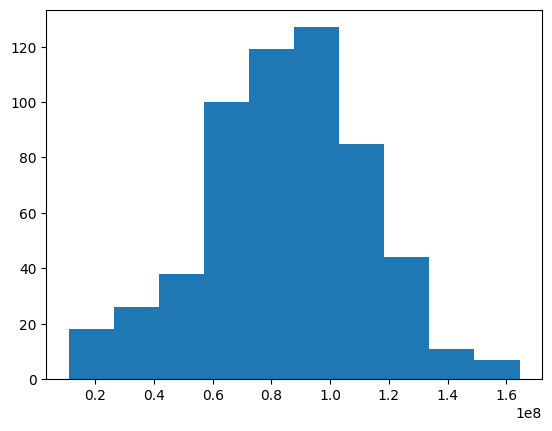

In [9]:
check = np.power(df_thomas["THALAMUS_1"], 2)
plt.hist(check)
stats.shapiro(check, nan_policy="omit")


(array([ 23.,  50.,  83., 137., 117.,  85.,  50.,  16.,  10.,   4.]),
 array([  2.559994 ,  27.2896887,  52.0193834,  76.7490781, 101.4787728,
        126.2084675, 150.9381622, 175.6678569, 200.3975516, 225.1272463,
        249.856941 ]),
 <BarContainer object of 10 artists>)

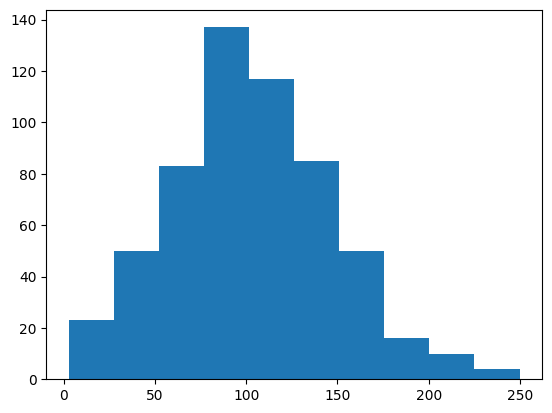

In [10]:
plt.hist(df_thomas["AV_2"])

## Analysis

In [ ]:
model_data = df_ms_z.join([df_thomas_z])

model = sm.OLS.from_formula(
    "choroid_volume ~ age + Female + tiv", data=model_data
).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         choroid_volume   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     41.32
Date:                Tue, 19 Aug 2025   Prob (F-statistic):           1.11e-23
Time:                        21:37:54   Log-Likelihood:                -611.05
No. Observations:                 468   AIC:                             1230.
Df Residuals:                     464   BIC:                             1247.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0339      0.042      0.817      0.4

### CP and Other Inflammatory Markers

In [11]:
outcomes = [
    "t2lv_logtrans",
    "THALAMUS_1",
    "brain",
    "grey",
    "white",
    "cortical_thickness",
    "ventricle_logtrans",
    "EDSS_sqrt",
    "SDMT",
    "PRL",
    "allCSF", 
    "periCSF"
]
covariates = "age + Female + tiv"

df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])

regression_results = run_regressions(model_data, covariates, "choroid_volume", outcomes)
regression_results.sort_values(by="coef", key=np.abs, ascending=False, inplace=True)
# regression_results.to_excel(fig_path / "choroid_vs_inflammatory_markers.xlsx")
regression_results

,coef,pvals,se,llci,ulci,ci,p_fdr,R2,coef_sig
ventricle_logtrans,0.620113,1.869062e-53,0.032682,0.550890,0.689335,"[0.550890, 0.689335]",2.242874e-52,0.550600,0.620113
THALAMUS_1,-0.423348,3.496056e-24,0.046542,-0.500794,-0.345901,"[-0.500794, -0.345901]",2.097633e-23,0.430558,-0.423348
t2lv_logtrans,0.335684,1.053844e-12,0.050267,0.245655,0.425712,"[0.245655, 0.425712]",2.529226e-12,0.187313,0.335684
cortical_thickness,-0.325829,1.913385e-13,0.045456,-0.410309,-0.241349,"[-0.410309, -0.241349]",5.740154e-13,0.324296,-0.325829
allCSF,0.308678,1.236271e-22,0.031264,0.249941,0.367416,"[0.249941, 0.367416]",4.945082e-22,0.661835,0.308678
brain,-0.297022,4.109655e-11,0.043998,-0.383336,-0.210707,"[-0.383336, -0.210707]",8.219309e-11,0.305914,-0.297022
white,-0.287184,2.694354e-09,0.044987,-0.380186,-0.194183,"[-0.380186, -0.194183]",4.618893e-09,0.188390,-0.287184
PRL,0.243937,5.000725e-06,0.067917,0.140160,0.347714,"[0.140160, 0.347714]",6.667633e-06,0.101605,0.243937
grey,-0.240896,2.062966e-08,0.045075,-0.323855,-0.157938,"[-0.323855, -0.157938]",3.094449e-08,0.358058,-0.240896
SDMT,-0.157169,1.236063e-03,0.054758,-0.252175,-0.062162,"[-0.252175, -0.062162]",1.348433e-03,0.174353,-0.157169


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    PRL   No. Observations:                  468
Model:                            GLM   Df Residuals:                      463
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -678.10
Date:                Tue, 19 Aug 2025   Deviance:                       923.77
Time:                        21:22:19   Pearson chi2:                 1.24e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3198
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.3484      0.059     -5.

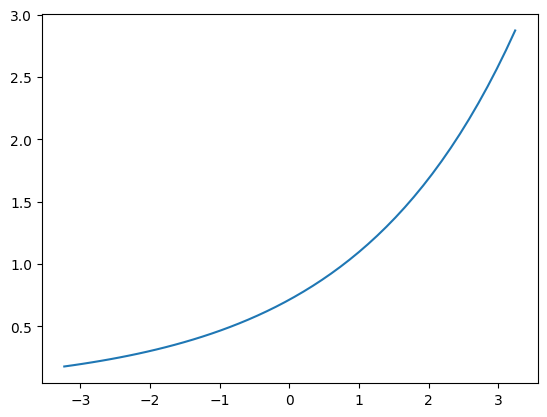

In [ ]:
model_data['PRL'] = df['PRL']
model = sm.GLM.from_formula(
    "PRL ~ choroid_volume + age + Female + tiv",
    data=model_data,
    family=sm.families.Poisson(),
).fit()
print(model.summary())

d = {
    "choroid_volume": np.linspace(
        model_data["choroid_volume"].min(), model_data["choroid_volume"].max()
    ),
    "age": [model_data["age"].mean()],
    "Female": [model_data["Female"].mean()],
    "tiv": [model_data["tiv"].mean()],
    "THALAMUS_1": [model_data["THALAMUS_1"].mean()],
}

test_data = (
    pd.MultiIndex.from_product(d.values(), names=d.keys())
    .to_frame()
    .reset_index(drop=True)
)
y = model.predict(test_data)
plt.plot(d['choroid_volume'], y)

In [ ]:
predictors = [
    "ventricle_logtrans",
    "THALAMUS_1",
    "cortical_thickness",
    "t2lv_logtrans",
    "PRL",
    "brain",
    "grey",
    "white",
]
covariates = "age + Female + tiv"

df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])

regression_results = run_regressions2(
    model_data, covariates, "choroid_volume", predictors
)
regression_results.sort_values(by="coef", key=np.abs, ascending=False, inplace=True)
regression_results.to_excel(fig_path / "choroid_vs_inflammatory_markers_reverse.xlsx")
regression_results

,coef,pvals,se,llci,ulci,ci,p_fdr,R2,coef_sig
ventricle_logtrans,0.647428,1.869062e-53,0.043853,0.575157,0.719700,"[0.575157, 0.719700]",1.495249e-52,0.523276,0.647428
THALAMUS_1,-0.471241,3.496056e-24,0.047756,-0.557449,-0.385033,"[-0.557449, -0.385033]",1.398422e-23,0.362813,-0.471241
cortical_thickness,-0.338748,1.913385e-13,0.050550,-0.426577,-0.250918,"[-0.426577, -0.250918]",5.102359e-13,0.291871,-0.338748
t2lv_logtrans,0.309534,1.053844e-12,0.051534,0.226519,0.392550,"[0.226519, 0.392550]",2.107689e-12,0.286722,0.309534
brain,-0.302623,4.109655e-11,0.046167,-0.390566,-0.214680,"[-0.390566, -0.214680]",6.575447e-11,0.275562,-0.302623
grey,-0.272763,2.062966e-08,0.050661,-0.366694,-0.178831,"[-0.366694, -0.178831]",2.357676e-08,0.256317,-0.272763
white,-0.256526,2.694354e-09,0.041973,-0.339600,-0.173453,"[-0.339600, -0.173453]",3.592473e-09,0.262655,-0.256526
PRL,0.180592,5.000725e-06,0.035828,0.103763,0.257420,"[0.103763, 0.257420]",5.000725e-06,0.239080,0.180592


#### Plot markers vs CP

In [ ]:
res = sm.OLS.from_formula(
    "choroid_volume ~ age + ventricle_volume + tiv", data=model_data
).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         choroid_volume   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     84.36
Date:                Tue, 19 Aug 2025   Prob (F-statistic):           1.47e-43
Time:                        15:41:10   Log-Likelihood:                -563.50
No. Observations:                 467   AIC:                             1135.
Df Residuals:                     463   BIC:                             1152.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0194      0.038  

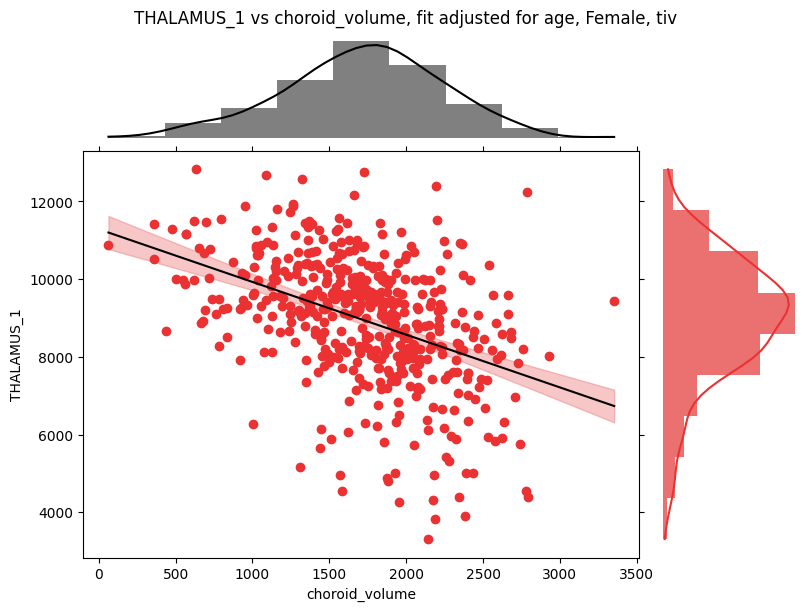

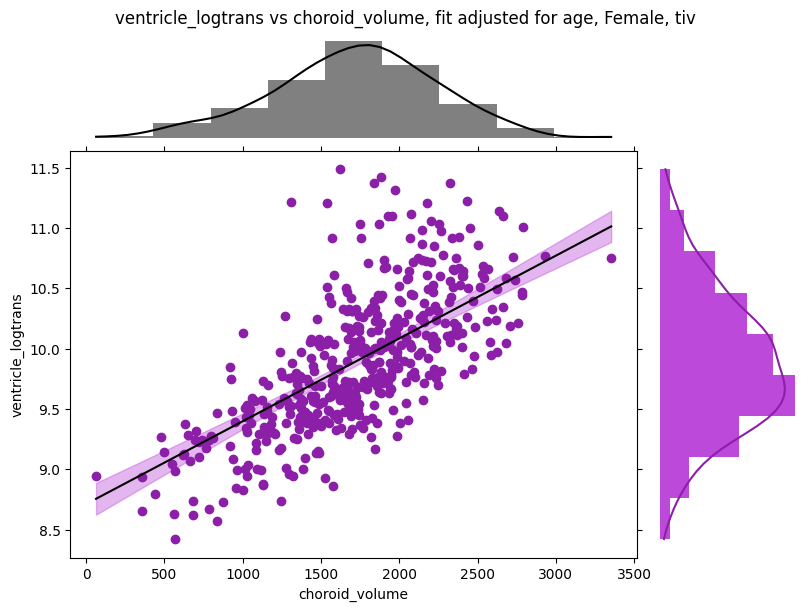

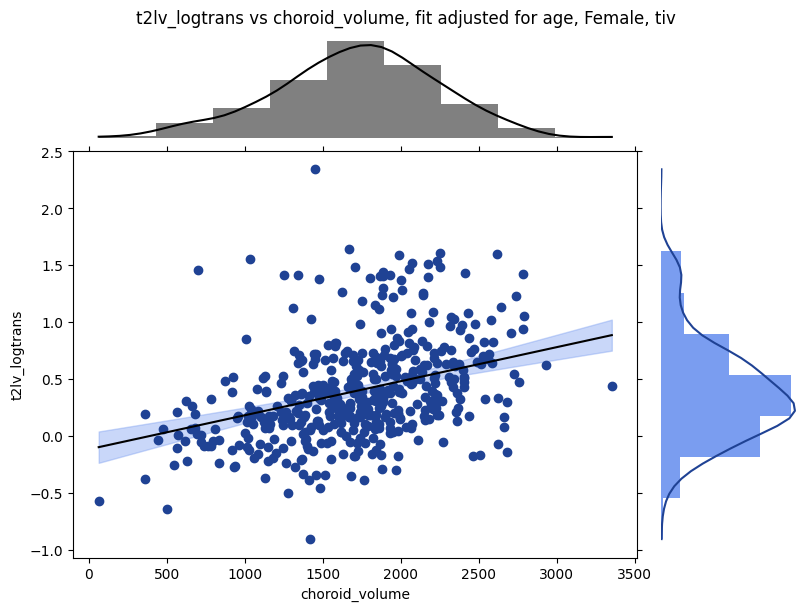

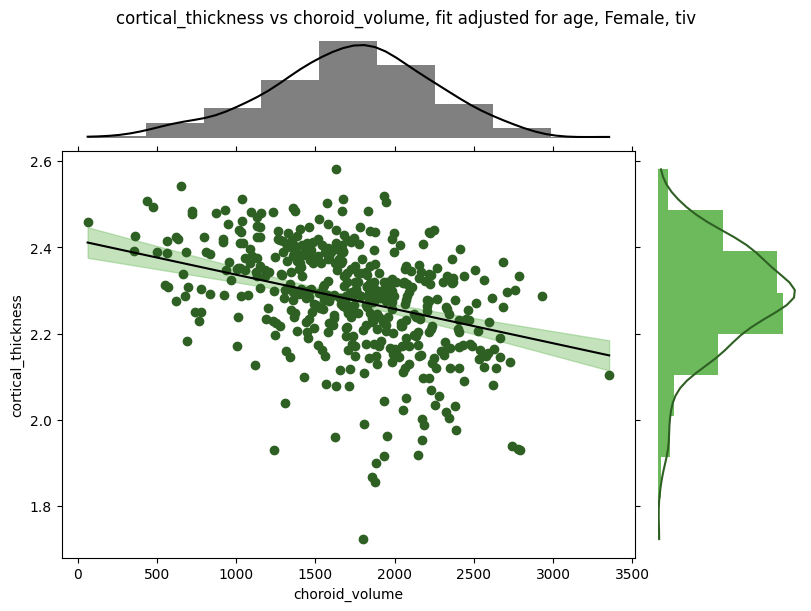

In [8]:
plot_data = df.join([df_thomas])
plot_data = plot_data[plot_data.dz_type2 == "MS"]
covariates = ["age", "Female", "tiv"]

x_name = "choroid_volume"
y_name = "THALAMUS_1"
title = f"{y_name} vs {x_name}, fit adjusted for {', '.join(covariates)}"
fig, axs = plot_regression(
    plot_data,
    x_name,
    y_name,
    covariates,
    color="red1",
    xlabel=x_name,
    ylabel=y_name,
    title=title,
)
fig.savefig(fig_path / f"plot_{y_name}_vs_{x_name}.png", dpi=300)

x_name = "choroid_volume"
y_name = "ventricle_logtrans"
title = f"{y_name} vs {x_name}, fit adjusted for {', '.join(covariates)}"
fig, axs = plot_regression(
    plot_data,
    x_name,
    y_name,
    covariates,
    color="purple1",
    xlabel=x_name,
    ylabel=y_name,
    title=title,
)
fig.savefig(fig_path / f"plot_{y_name}_vs_{x_name}.png", dpi=300)

x_name = "choroid_volume"
y_name = "t2lv_logtrans"
title = f"{y_name} vs {x_name}, fit adjusted for {', '.join(covariates)}"
fig, axs = plot_regression(
    plot_data,
    x_name,
    y_name,
    covariates,
    color="blue1",
    xlabel=x_name,
    ylabel=y_name,
    title=title,
)
fig.savefig(fig_path / f"plot_{y_name}_vs_{x_name}.png", dpi=300)

x_name = "choroid_volume"
y_name = "cortical_thickness"
title = f"{y_name} vs {x_name}, fit adjusted for {', '.join(covariates)}"
fig, axs = plot_regression(
    plot_data,
    x_name,
    y_name,
    covariates,
    color="green1",
    xlabel=x_name,
    ylabel=y_name,
    title=title,
)
fig.savefig(fig_path / f"plot_{y_name}_vs_{x_name}.png", dpi=300)

### HIPS-THOMAS and Inflammatory Markers

#### Each side for cartoon figure

In [7]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data_left = df_ms_z.join([df_thomas_left_z])
model_data_right = df_ms_z.join([df_thomas_right_z])

structs = hips_thomas_ref[thalamic_nuclei]
covariates = "age + Female + tiv + THALAMUS_1"

predictors = ["choroid_volume"]
regression_results_left = {}
regression_results_right = {}
for i, predictor in enumerate(predictors):
    results_left = run_regressions(model_data_left, covariates, predictor, structs)
    results_left = fix_hipsthomas_regression_results(results_left)
    results_right = run_regressions(model_data_right, covariates, predictor, structs)
    results_right = fix_hipsthomas_regression_results(results_right)
    all_coefs = pd.concat([results_left.coef, results_right.coef])
    bins = np.linspace(all_coefs.min() - 0.0001, all_coefs.max() - 0.0001, 10)
    ranks = np.digitize(results_left.coef, bins)
    results_left.insert(1, "bin", ranks)
    ranks = np.digitize(results_right.coef, bins)
    results_right.insert(1, "bin", ranks)
    regression_results_left[predictor] = results_left
    regression_results_right[predictor] = results_right

In [32]:
# tmp, creating a table to test the automated diagram creation. can delete later
left_table = regression_results_left["choroid_volume"][['struct', 'bin']]
left_table.insert(1, "Side", "L")
right_table = regression_results_right["choroid_volume"][['struct', 'bin']]
right_table.insert(1, "Side", "R")

table = pd.concat(
    [left_table, right_table],
    ignore_index=True,
)
table.insert(2, "struct_index", 0)
for i, row in table.iterrows():
    table.loc[i, 'struct_index'] = hips_thomas_invref[row['struct']]
table.to_csv("/home/srs-9/Projects/thalamus_diagram/test_table.csv", index=False)

#### Bilateral for table

In [20]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])

structs = hips_thomas_ref[thalamic_nuclei]
covariates = "age + Female + tiv + THALAMUS_1"

predictors = [
    "choroid_volume",
    "ventricle_volume",
    "cortical_thickness",
    "t2lv",
    "PRL",
    "brain",
    "white",
    "grey",
]
regression_results = {}
for i, predictor in enumerate(predictors):
    result = run_regressions(model_data, covariates, predictor, structs)
    regression_results[predictor] = fix_hipsthomas_regression_results(result)

save_path = fig_path / "hipsthomas_and_inflammatory_markers.xlsx"

with pd.ExcelWriter(save_path) as writer:
    for predictor in regression_results:
        regression_results[predictor].to_excel(writer, sheet_name=predictor)
regression_results['choroid_volume']

,struct,coef,pvals,se,llci,ulci,ci,p_fdr,R2,coef_sig
2,AV_2,0.035563,3.376318e-01,0.041196,-0.037245,0.108370,"[-0.037245, 0.108370]",0.337632,0.561576,0.000000
4,VA_4,0.179250,1.321608e-07,0.029377,0.113523,0.244976,"[0.113523, 0.244976]",0.000001,0.674796,0.179250
5,VLa_5,0.140753,1.350786e-04,0.037000,0.068899,0.212607,"[0.068899, 0.212607]",0.000450,0.587137,0.140753
6,VLP_6,0.112282,7.848105e-06,0.024144,0.063472,0.161091,"[0.063472, 0.161091]",0.000039,0.817064,0.112282
7,VPL_7,0.088219,2.359570e-03,0.027668,0.031524,0.144915,"[0.031524, 0.144915]",0.004719,0.751606,0.088219
8,Pul_8,-0.040044,3.383510e-02,0.018009,-0.077016,-0.003072,"[-0.077016, -0.003072]",0.042294,0.894306,-0.040044
9,LGN_9,-0.073108,5.723033e-02,0.041479,-0.148471,0.002255,"[-0.148471, 0.002255]",0.063589,0.558797,0.000000
10,MGN_10,-0.073235,2.034436e-02,0.030393,-0.135054,-0.011415,"[-0.135054, -0.011415]",0.029063,0.705842,-0.073235
11,CM_11,-0.102487,3.888490e-03,0.037553,-0.171894,-0.033081,"[-0.171894, -0.033081]",0.006481,0.622440,-0.102487
12,MD_Pf_12,-0.069110,1.179600e-03,0.021319,-0.110717,-0.027503,"[-0.110717, -0.027503]",0.002949,0.871944,-0.069110


In [ ]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas2_z])

structs = list(grouped_nuclei)
covariates = "age + Female + tiv + THALAMUS_1"

predictors = [
    "choroid_volume",
    "ventricle_volume",
    "periCSF",
    "third_ventricle",
    "cortical_thickness",
    "t2lv",
    "PRL",
    "brain",
    "white",
    "grey",
]
regression_results = {}
for i, predictor in enumerate(predictors):
    regression_results[predictor] = run_regressions(model_data, covariates, predictor, structs)

save_path = fig_path / "hipsthomas2_and_inflammatory_markers_thalamus_control.xlsx"

with pd.ExcelWriter(save_path) as writer:
    for predictor in regression_results:
        regression_results[predictor].to_excel(writer, sheet_name=predictor)
regression_results['choroid_volume']

,coef,pvals,se,llci,ulci,ci,p_fdr,R2,coef_sig
anterior,0.035563,3.376318e-01,0.041196,-0.037245,0.108370,"[-0.037245, 0.108370]",3.376318e-01,0.561576,0.000000
ventral,0.128639,1.243761e-09,0.019219,0.087875,0.169403,"[0.087875, 0.169403]",4.975045e-09,0.871857,0.128639
medial,-0.076843,9.024345e-05,0.020218,-0.115070,-0.038617,"[-0.115070, -0.038617]",1.804869e-04,0.891332,-0.076843
posterior,-0.045134,1.280286e-02,0.017482,-0.080626,-0.009642,"[-0.080626, -0.009642]",1.707049e-02,0.903201,-0.045134


In [15]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas2_z])
structs = list(grouped_nuclei)
print(structs)
predictors = [
    "choroid_volume",
    "ventricle_volume",
    "cortical_thickness",
    "t2lv",
    "PRL",
    "brain",
    "white",
    "grey",
]

results_by_struct, results_by_predictor = run_regressions_refactored(model_data, structs, predictors, covariates="age + Female + tiv + THALAMUS_1")

save_path = fig_path / "hipsthomas2_and_inflammatory_markers_by_struct_thalamus_control.xlsx"
# with pd.ExcelWriter(save_path) as writer:
#     for struct in results_by_struct:
#         results_to_save = results_by_struct[struct]
#         results_to_save = results_to_save[['coef', 'ci', 'p_fdr', 'R2']]
#         results_to_save[['coef', 'p_fdr', 'R2']] = results_to_save[['coef', 'p_fdr', 'R2']].map("{:.3f}".format)
#         results_to_save.to_excel(writer, sheet_name=struct)

['anterior', 'ventral', 'medial', 'posterior']
pvals [0.38844142 0.16249625 0.37365859 0.27533535 0.02898618 0.83851556
 0.5343214  0.80933273]
fdr_alpha 0.05
fdr_method fdr_bh
pvals [6.33679447e-11 2.02160182e-10 9.41359399e-03 7.60557861e-02
 1.78642023e-01 7.36851526e-01 3.14869320e-01 7.94292057e-01]
fdr_alpha 0.05
fdr_method fdr_bh
pvals [1.63566222e-04 4.51666574e-08 4.67498367e-02 3.34799625e-01
 6.33128343e-01 2.26079991e-01 8.94299025e-03 7.85176172e-01]
fdr_alpha 0.05
fdr_method fdr_bh
pvals [1.01355584e-02 2.43065566e-01 3.74441641e-01 4.57817925e-02
 4.08454133e-04 7.24127962e-01 9.07867420e-01 6.52930476e-01]
fdr_alpha 0.05
fdr_method fdr_bh


In [58]:
results_to_save[['coef', 'p_fdr', 'R2']] = results_to_save[['coef', 'p_fdr', 'R2']].applymap("{:.3f}".format)
results_to_save

/tmp/ipykernel_6777/2703479563.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results_to_save[['coef', 'p_fdr', 'R2']] = results_to_save[['coef', 'p_fdr', 'R2']].applymap("{:.3f}".format)


,coef,pval,p_fdr,se,llci,ulci,ci,R2,coef_sig
predictor,,,,,,,,,
choroid_volume,-0.045,0.010136,0.041,0.017482,-0.079487,-0.010781,"[-0.0795, -0.0108]",0.903,-0.045134
ventricle_volume,-0.027,0.243066,0.486,0.023316,-0.073073,0.018566,"[-0.0731, 0.0186]",0.904,0.000000
cortical_thickness,0.021,0.374442,0.599,0.023869,-0.025685,0.068127,"[-0.0257, 0.0681]",0.902,0.000000
t2lv,-0.043,0.045782,0.122,0.021590,-0.085669,-0.000814,"[-0.0857, -0.000814]",0.903,0.000000
PRL,-0.056,0.000408,0.003,0.015638,-0.086409,-0.024949,"[-0.0864, -0.0249]",0.905,-0.055679
brain,0.006,0.724128,0.828,0.017809,-0.028708,0.041287,"[-0.0287, 0.0413]",0.902,0.000000
white,0.002,0.907867,0.908,0.015810,-0.029238,0.032899,"[-0.0292, 0.0329]",0.902,0.000000
grey,0.009,0.652930,0.828,0.020023,-0.030337,0.048358,"[-0.0303, 0.0484]",0.902,0.000000


In [56]:
results_to_save.style.format("{:.4f}")
results_to_save

,coef,pval,p_fdr,se,llci,ulci,ci,R2,coef_sig
predictor,,,,,,,,,
choroid_volume,-0.045134,0.010136,0.040542,0.017482,-0.079487,-0.010781,"[-0.0795, -0.0108]",0.903201,-0.045134
ventricle_volume,-0.027254,0.243066,0.486131,0.023316,-0.073073,0.018566,"[-0.0731, 0.0186]",0.903515,0.000000
cortical_thickness,0.021221,0.374442,0.599107,0.023869,-0.025685,0.068127,"[-0.0257, 0.0681]",0.902105,0.000000
t2lv,-0.043242,0.045782,0.122085,0.021590,-0.085669,-0.000814,"[-0.0857, -0.000814]",0.903404,0.000000
PRL,-0.055679,0.000408,0.003268,0.015638,-0.086409,-0.024949,"[-0.0864, -0.0249]",0.904848,-0.055679
brain,0.006290,0.724128,0.827575,0.017809,-0.028708,0.041287,"[-0.0287, 0.0413]",0.901919,0.000000
white,0.001831,0.907867,0.907867,0.015810,-0.029238,0.032899,"[-0.0292, 0.0329]",0.901895,0.000000
grey,0.009010,0.652930,0.827575,0.020023,-0.030337,0.048358,"[-0.0303, 0.0484]",0.901940,0.000000


In [36]:
results_by_struct['anterior']  

,coef,pval,p_fdr,se,llci,ulci,ci,R2,coef_sig
predictor,,,,,,,,,
choroid_volume,0.035563,0.388441,0.621506,0.041196,-0.045392,0.116517,"[-0.045392, 0.116517]",0.561576,0.0
ventricle_volume,0.066048,0.162496,0.621506,0.047212,-0.026730,0.158826,"[-0.026730, 0.158826]",0.562531,0.0
cortical_thickness,0.041356,0.373659,0.621506,0.046441,-0.049906,0.132618,"[-0.049906, 0.132618]",0.561569,0.0
t2lv,-0.033040,0.275335,0.621506,0.030252,-0.092489,0.026409,"[-0.092489, 0.026409]",0.561651,0.0
PRL,-0.055945,0.028986,0.231889,0.025540,-0.106134,-0.005757,"[-0.106134, -0.005757]",0.563913,0.0
brain,0.007384,0.838516,0.838516,0.036211,-0.063774,0.078541,"[-0.063774, 0.078541]",0.560741,0.0
white,0.020867,0.534321,0.712429,0.033555,-0.045072,0.086806,"[-0.045072, 0.086806]",0.561101,0.0
grey,-0.009028,0.809333,0.838516,0.037394,-0.082511,0.064455,"[-0.082511, 0.064455]",0.560753,0.0


In [ ]:
# ...existing code...
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas2_z])

structs = list(grouped_nuclei)
covariates = "age + Female + tiv + THALAMUS_1"

predictors = [
    "choroid_volume",
    "ventricle_volume",
    "cortical_thickness",
    "t2lv",
    "PRL",
    "brain",
    "white",
    "grey",
]

# produce results organized by struct (one DataFrame per struct, rows=predictors)
results_by_struct = {}
for struct in structs:
    coefs = {}
    pvals = {}
    se = {}
    llci = {}
    ulci = {}
    ci_str = {}
    r2 = {}

    plus_cov = f"+ {covariates}" if covariates else ""

    for pred in predictors:
        formula = f"{struct} ~ {pred} {plus_cov}"
        res = sm.OLS.from_formula(formula, data=model_data).fit()
        coefs[pred] = res.params.get(pred, np.nan)
        pvals[pred] = res.pvalues.get(pred, np.nan)
        se[pred] = res.HC0_se.get(pred, np.nan)
        ci = res.conf_int()
        if pred in ci.index:
            llci[pred] = ci.loc[pred, 0]
            ulci[pred] = ci.loc[pred, 1]
            ci_str[pred] = f"[{llci[pred]:.6f}, {ulci[pred]:.6f}]"
        else:
            llci[pred] = np.nan
            ulci[pred] = np.nan
            ci_str[pred] = ""
        r2[pred] = res.rsquared_adj

    df_struct = pd.DataFrame(
        {
            "coef": pd.Series(coefs),
            "pvals": pd.Series(pvals),
            "se": pd.Series(se),
            "llci": pd.Series(llci),
            "ulci": pd.Series(ulci),
            "ci": pd.Series(ci_str),
            "R2": pd.Series(r2),
        }
    )

    # FDR correction across predictors for this struct
    try:
        # SciPy newer versions provide false_discovery_control
        df_struct["p_fdr"] = stats.false_discovery_control(df_struct["pvals"], method="bh")
    except Exception:
        from statsmodels.stats.multitest import multipletests
        _, p_fdr_vals, _, _ = multipletests(df_struct["pvals"].fillna(1.0).values, method="fdr_bh")
        df_struct["p_fdr"] = pd.Series(p_fdr_vals, index=df_struct.index)

    # mark significant coefficient (coef_sig) based on p_fdr < 0.05
    df_struct["coef_sig"] = df_struct["coef"].where(df_struct["p_fdr"] < 0.05, 0.0)

    results_by_struct[struct] = df_struct

# also produce regression_results keyed by predictor for compatibility with other cells
regression_results = {}
for pred in predictors:
    df_pred = pd.DataFrame(index=structs, columns=results_by_struct[structs[0]].columns)
    for struct in structs:
        df_pred.loc[struct, :] = results_by_struct[struct].loc[pred, :].values
    regression_results[pred] = df_pred

# ...existing code...

,coef,pvals,se,llci,ulci,ci,p_fdr,R2,coef_sig
choroid_volume,-0.045134,0.012803,0.017482,-0.080626,-0.009642,"[-0.080626, -0.009642]",0.01707,0.903201,-0.045134
ventricle_volume,-0.027254,0.174514,0.023316,-0.066635,0.012128,"[-0.066635, 0.012128]",0.174514,0.903515,0.0
cortical_thickness,0.021221,0.317568,0.023869,-0.020458,0.062899,"[-0.020458, 0.062899]",0.339621,0.902105,0.0
t2lv,-0.043242,0.007428,0.02159,-0.074844,-0.011639,"[-0.074844, -0.011639]",0.014857,0.903404,-0.043242
PRL,-0.055679,0.000172,0.015638,-0.084561,-0.026797,"[-0.084561, -0.026797]",0.000687,0.904848,-0.055679
brain,0.00629,0.723275,0.017809,-0.028596,0.041175,"[-0.028596, 0.041175]",0.838521,0.901919,0.0
white,0.001831,0.907683,0.01581,-0.029176,0.032837,"[-0.029176, 0.032837]",0.907683,0.901895,0.0
grey,0.00901,0.637071,0.020023,-0.028494,0.046514,"[-0.028494, 0.046514]",0.816736,0.90194,0.0


#### Partial Correlation

Regress choroid_volume against whole thalamus and covariates, then do a regression of each subnucleus against the residuals of the choroid_volume

In [18]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])

structs = hips_thomas_ref[[1] + thalamic_nuclei]
covariates = "age + Female + tiv"
res = sm.OLS.from_formula(f"choroid_volume ~ {covariates}", model_data).fit()
model_data['choroid_resid'] = res.resid

struct_resid_names = []
for struct in structs:
    res = sm.OLS.from_formula(f"{struct} ~ {covariates}", model_data).fit()
    model_data[f"{struct}_resid"] = res.resid
    struct_resid_names.append(f"{struct}_resid")

result = run_regressions(model_data, "", "choroid_resid", struct_resid_names)
result

,coef,pvals,se,llci,ulci,ci,p_fdr,R2,coef_sig
THALAMUS_1_resid,-0.423348,2.495994e-24,0.046542,-0.500543,-0.346152,"[-0.500543, -0.346152]",9.151976e-24,0.197781,-0.423348
AV_2_resid,-0.255076,4.336441e-09,0.045319,-0.338835,-0.171318,"[-0.338835, -0.171318]",5.300094e-09,0.069374,-0.255076
VA_4_resid,-0.103402,9.484698e-03,0.041908,-0.181406,-0.025397,"[-0.181406, -0.025397]",9.484698e-03,0.012237,-0.103402
VLa_5_resid,-0.108726,6.757867e-03,0.040989,-0.187255,-0.030197,"[-0.187255, -0.030197]",7.433654e-03,0.013524,-0.108726
VLP_6_resid,-0.261331,4.997422e-10,0.049579,-0.342151,-0.180511,"[-0.342151, -0.180511]",6.871456e-10,0.077756,-0.261331
VPL_7_resid,-0.283356,1.200628e-10,0.049046,-0.367865,-0.198848,"[-0.367865, -0.198848]",1.886700e-10,0.083258,-0.283356
Pul_8_resid,-0.449417,1.652242e-24,0.046202,-0.531007,-0.367826,"[-0.531007, -0.367826]",9.087333e-24,0.199188,-0.449417
LGN_9_resid,-0.391036,7.613177e-17,0.049196,-0.479738,-0.302333,"[-0.479738, -0.302333]",1.395749e-16,0.136854,-0.391036
MGN_10_resid,-0.379562,1.031437e-19,0.040278,-0.458003,-0.301122,"[-0.458003, -0.301122]",2.836451e-19,0.160698,-0.379562
CM_11_resid,-0.368529,1.072658e-18,0.041843,-0.447118,-0.289939,"[-0.447118, -0.289939]",2.359848e-18,0.152314,-0.368529


In [24]:
print(stats.pearsonr(model_data['choroid_resid'], model_data['THALAMUS_1_resid']).statistic)
print(stats.pearsonr(model_data['choroid_resid'], model_data['MD_Pf_12_resid']).statistic)
print(stats.pearsonr(model_data['THALAMUS_1_resid'], model_data['MD_Pf_12_resid']).statistic)

-0.44665285240008945
-0.46261911771709474
0.9131630652698831


In [16]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])
model_data = pd.concat([model_data, pd.get_dummies(model_data["dz_type5"])], axis=1)

structs = hips_thomas_ref[thalamic_nuclei]


formula = "choroid_volume ~ ventricle_volume + age + Female + tiv + THALAMUS_1"
res = sm.OLS.from_formula(formula, data=model_data).fit()
model_data["choroid_resid"] = res.resid

predictor1 = "choroid_volume"
predictor2 = "ventricle_volume"
predictor3 = "choroid_resid"
covariates1 = "age + Female + tiv + ventricle_volume + THALAMUS_1"
covariates2 = "age + Female + tiv + choroid_volume"
covariates3 = "age + Female + tiv"
result = run_regressions(model_data, covariates1, predictor1, structs)
# result.to_excel(fig_path / "hipsthomas_ventricle_choroid_control.xlsx")
result

,coef,pvals,se,llci,ulci,ci,p_fdr,R2,coef_sig
AV_2,0.021069,0.584037,0.041681,-0.054501,0.096639,"[-0.054501, 0.096639]",0.584037,0.561865,0.000000
VA_4,0.147390,0.000016,0.029790,0.080928,0.213852,"[0.080928, 0.213852]",0.000162,0.689834,0.147390
VLa_5,0.121646,0.001380,0.039670,0.047369,0.195923,"[0.047369, 0.195923]",0.004601,0.590731,0.121646
VLP_6,0.087606,0.000623,0.025361,0.037634,0.137578,"[0.037634, 0.137578]",0.003116,0.822359,0.087606
VPL_7,0.052966,0.072027,0.028219,-0.004760,0.110691,"[-0.004760, 0.110691]",0.090034,0.761446,0.000000
Pul_8,-0.040618,0.036418,0.019458,-0.078658,-0.002579,"[-0.078658, -0.002579]",0.072837,0.895837,0.000000
LGN_9,-0.044989,0.256280,0.040753,-0.122769,0.032792,"[-0.122769, 0.032792]",0.284755,0.564666,0.000000
MGN_10,-0.060316,0.065266,0.030435,-0.124461,0.003828,"[-0.124461, 0.003828]",0.090034,0.706628,0.000000
CM_11,-0.083417,0.022884,0.039041,-0.155219,-0.011615,"[-0.155219, -0.011615]",0.057209,0.625229,0.000000
MD_Pf_12,-0.040051,0.062183,0.021684,-0.082149,0.002048,"[-0.082149, 0.002048]",0.090034,0.878465,0.000000


In [ ]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])
model_data = pd.concat([model_data, pd.get_dummies(model_data["dz_type5"])], axis=1)

structs = hips_thomas_ref
pvals = {}
coefs = {}
interaction_coefs = {}
interaction_p = {}
se = {}
for struct in structs:
    formula = f"{struct} ~ choroid_volume + age + Female + tiv"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues["dzdur"]
    coefs[struct] = res.params["dzdur"]
    interaction_coefs[struct] = res.params["choroid_volume:dzdur"]
    interaction_p[struct] = res.pvalues["choroid_volume:dzdur"]

regression_results = pd.DataFrame(
    {
        "coef": coefs,
        "pvals": pvals,
        "interaction_coefs": interaction_coefs,
        "interaction_p": interaction_p,
    }
)
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.index:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))
regression_results.index = new_index

regression_results = regression_results.sort_values(by="coef")
regression_results

,struct,coef,pvals,interaction_coefs,interaction_p
12,MD_Pf_12,-0.255628,1.068645e-07,0.020159,0.615066
1,THALAMUS_1,-0.253020,2.528566e-08,0.007496,0.842759
8,Pul_8,-0.246496,3.117359e-07,0.017728,0.659224
7,VPL_7,-0.191133,1.315883e-04,-0.046530,0.267921
9,LGN_9,-0.181375,5.739029e-04,-0.031983,0.470324
26,Acc_26,-0.174475,1.371580e-04,0.005611,0.883885
6,VLP_6,-0.169492,4.072560e-04,-0.033985,0.399242
30,GPi_30,-0.164983,1.081058e-03,0.118227,0.005570
10,MGN_10,-0.158180,7.163014e-04,0.041144,0.295711
31,Put_31,-0.157012,4.071974e-04,0.020878,0.576063


In [9]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Amy_34   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     18.56
Date:                Tue, 19 Aug 2025   Prob (F-statistic):           2.33e-19
Time:                        15:39:24   Log-Likelihood:                -625.43
No. Observations:                 468   AIC:                             1265.
Df Residuals:                     461   BIC:                             1294.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0132 

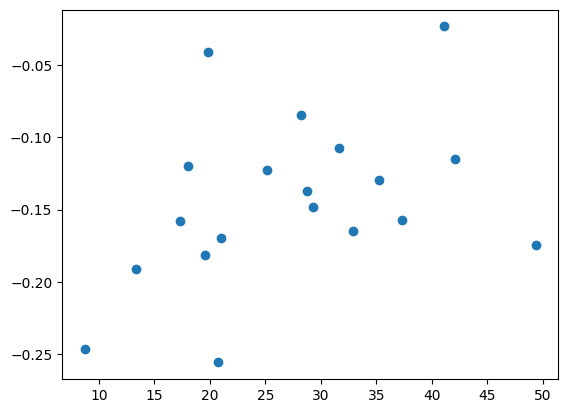

In [ ]:
regression_results["dist"] = mni_dists["left_exposure"]
plt.scatter(regression_results["dist"], regression_results["coef"])

In [20]:
structs = df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]
structs = df_thomas2.columns

df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas2_z])

predictor1 = "choroid_volume"
predictor2 = "ventricle_volume"
covariates1 = "age + Female + tiv"
covariates2 = "age + Female + tiv + choroid_volume"
result = run_regressions(model_data, covariates1, predictor1, structs)
result[["coef", "pvals", "p_fdr", "coef_sig"]]
# result.to_excel(fig_path / "hipsthomas_grouped_ventricle_choroid_control.xlsx")

,coef,pvals,p_fdr,coef_sig
anterior,-0.255076,4.860704e-09,4.860704e-09,-0.255076
ventral,-0.248599,8.783408e-10,1.097926e-09,-0.248599
medial,-0.471809,1.728635e-27,8.643176e-27,-0.471809
posterior,-0.455755,4.244640e-25,1.061160e-24,-0.455755
THALAMUS_1,-0.423348,3.496056e-24,5.826759e-24,-0.423348


In [29]:
formula = "medial ~ choroid_volume + ventricle_volume + periCSF + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())
res.wald_test("choroid_volume = ventricle_volume")

                            OLS Regression Results                            
Dep. Variable:                 medial   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     123.9
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           8.61e-93
Time:                        22:55:46   Log-Likelihood:                -447.13
No. Observations:                 467   AIC:                             908.3
Df Residuals:                     460   BIC:                             937.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0400      0.029  

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[38.31506539]]), p=1.3339345629003796e-09, df_denom=460, df_num=1>

In [24]:
formula = "choroid_volume ~ medial + ventral + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         choroid_volume   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     61.19
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           7.12e-49
Time:                        22:53:34   Log-Likelihood:                -547.55
No. Observations:                 468   AIC:                             1107.
Df Residuals:                     462   BIC:                             1132.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0023      0.036     -0.063      0.9

#### Deep Gray

In [7]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])

structs = hips_thomas_ref[deep_grey]
covariates = "age + Female  + tiv"

predictors = ["choroid_volume", "ventricle_volume", "cortical_thickness", "t2lv", "PRL"]
regression_results = {}
for i, predictor in enumerate(predictors):
    result = run_regressions(model_data, covariates, predictor, structs)
    regression_results[predictor] = fix_hipsthomas_regression_results(result)

save_path = fig_path / "deep_grey_and_inflammatory_markers.xlsx"

with pd.ExcelWriter(save_path) as writer:
    for predictor in regression_results:
        regression_results[predictor].to_excel(writer, sheet_name=predictor)

In [8]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])
model_data = pd.concat([model_data, pd.get_dummies(model_data["dz_type5"])], axis=1)

structs = hips_thomas_ref[deep_grey]

predictor1 = "choroid_volume"
predictor2 = "ventricle_volume"
covariates1 = "age + Female + tiv + ventricle_volume"
covariates2 = "age + Female + tiv + choroid_volume"
result_choroid = run_regressions(model_data, covariates1, predictor1, structs)
result_ventricle = run_regressions(model_data, covariates2, predictor2, structs)

save_path = fig_path / "deep_grey_choroid_ventricle_model.xlsx"

with pd.ExcelWriter(save_path) as writer:
    result_choroid.to_excel(writer, sheet_name="choroid_volume")
    result_ventricle.to_excel(writer, sheet_name="ventricle_volume")

result_choroid

,coef,pvals,se,llci,ulci,ci,p_fdr,R2,coef_sig
Hb_13,-0.139660,0.009694,0.052388,-0.245324,-0.033996,"[-0.245324, -0.033996]",0.029082,0.146131,-0.139660
MTT_14,0.009976,0.833166,0.044323,-0.083037,0.102988,"[-0.083037, 0.102988]",0.833166,0.267961,0.000000
Acc_26,-0.085925,0.034027,0.040419,-0.165345,-0.006505,"[-0.165345, -0.006505]",0.051041,0.537562,0.000000
Cau_27,-0.104329,0.026438,0.048507,-0.196395,-0.012263,"[-0.196395, -0.012263]",0.047589,0.380276,-0.104329
Cla_28,-0.115504,0.004682,0.041041,-0.195370,-0.035637,"[-0.195370, -0.035637]",0.021070,0.524163,-0.115504
GPe_29,-0.047593,0.306697,0.048599,-0.138988,0.043802,"[-0.138988, 0.043802]",0.394325,0.350448,0.000000
GPi_30,-0.045101,0.355478,0.044463,-0.140921,0.050720,"[-0.140921, 0.050720]",0.399913,0.282617,0.000000
Put_31,-0.090843,0.025448,0.039535,-0.170475,-0.011212,"[-0.170475, -0.011212]",0.047589,0.492876,-0.090843
RN_32,-0.131088,0.001506,0.043124,-0.211776,-0.050400,"[-0.211776, -0.050400]",0.013558,0.485070,-0.131088


## Choroid and Disease Duration

Spline analysis

In [ ]:
from patsy import cr  # make cr() visible in the eval namespace
from sklearn.preprocessing import StandardScaler

n_splines = 3
# time_pts = [2, 15, 32]
# time_pt_colors = ["steelblue", "burlywood", "firebrick"]
time_pts = [2, 16]
time_pt_colors = ["steelblue", "firebrick"]

scaler_dzdur = StandardScaler()
scaler_cp = StandardScaler()

raw_data = df[df_z.dz_type2 == "MS"].join([df_thomas2])
model_data = df_z[df_z.dz_type2 == "MS"]
model_data = model_data.join([df_thomas2_z])
model_data['THALAMUS_1'] = df_thomas_z['THALAMUS_1']
model_data["dzdur"] = scaler_dzdur.fit_transform(
    raw_data.loc[model_data.index, ["dzdur"]]
)
model_data["choroid_volume"] = scaler_cp.fit_transform(
    raw_data.loc[model_data.index, ["choroid_volume"]]
)

scaler_thals = {}
models = {}

L, U = np.quantile(
    model_data['dzdur'], [0.05, 0.95]
)  # boundary knots (choose sensibly)
k1 = np.quantile(model_data['dzdur'], 0.50)  # one interior knot (e.g., median)

structs = df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]
for thalamus_label in structs:
    scaler_thals[thalamus_label] = StandardScaler()

    model_data[thalamus_label] = scaler_thals[thalamus_label].fit_transform(
        raw_data.loc[model_data.index, [thalamus_label]] / 1000
    )

    models[thalamus_label] = sm.OLS.from_formula(
        f"{thalamus_label} ~ choroid_volume * cr(dzdur, df=2, constraints='center') + age + Female + tiv",
        data=model_data,
    ).fit()


dzdur_levels = scaler_dzdur.transform([[time_pt] for time_pt in time_pts]).flatten()
d = {
    "choroid_volume": np.linspace(
        model_data["choroid_volume"].min(), model_data["choroid_volume"].max()
    ),
    "dzdur": dzdur_levels,
    "age": [model_data["age"].mean()],
    "Female": [model_data["Female"].mean()],
    "tiv": [model_data["tiv"].mean()],
    "THALAMUS_1": [model_data["THALAMUS_1"].mean()],
}

test_data = (
    pd.MultiIndex.from_product(d.values(), names=d.keys())
    .to_frame()
    .reset_index(drop=True)
)

for struct in structs:
    model = models[struct]
    pred = model.get_prediction(test_data).summary_frame(alpha=0.05)

    # test_data["fit"] = scaler_thal.inverse_transform([pred["mean"]]).flatten()
    # test_data["lower"] = scaler_thal.inverse_transform([pred["mean_ci_lower"]]).flatten()
    # test_data["upper"] = scaler_thal.inverse_transform([pred["mean_ci_upper"]]).flatten()
    test_data[f"{struct}_fit"] = pred["mean"]
    test_data[f"{struct}_lower"] = pred["mean_ci_lower"]
    test_data[f"{struct}_upper"] = pred["mean_ci_upper"]

test_data["cp_raw"] = scaler_cp.inverse_transform(
    [test_data["choroid_volume"]]
).flatten()
test_data["dzdur_raw"] = scaler_dzdur.inverse_transform([test_data["dzdur"]]).flatten()

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [32]:
print(models['posterior'].summary())

                            OLS Regression Results                            
Dep. Variable:              posterior   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     41.31
Date:                Mon, 18 Aug 2025   Prob (F-statistic):           1.36e-49
Time:                        22:38:26   Log-Likelihood:                -537.16
No. Observations:                 468   AIC:                             1092.
Df Residuals:                     459   BIC:                             1130.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

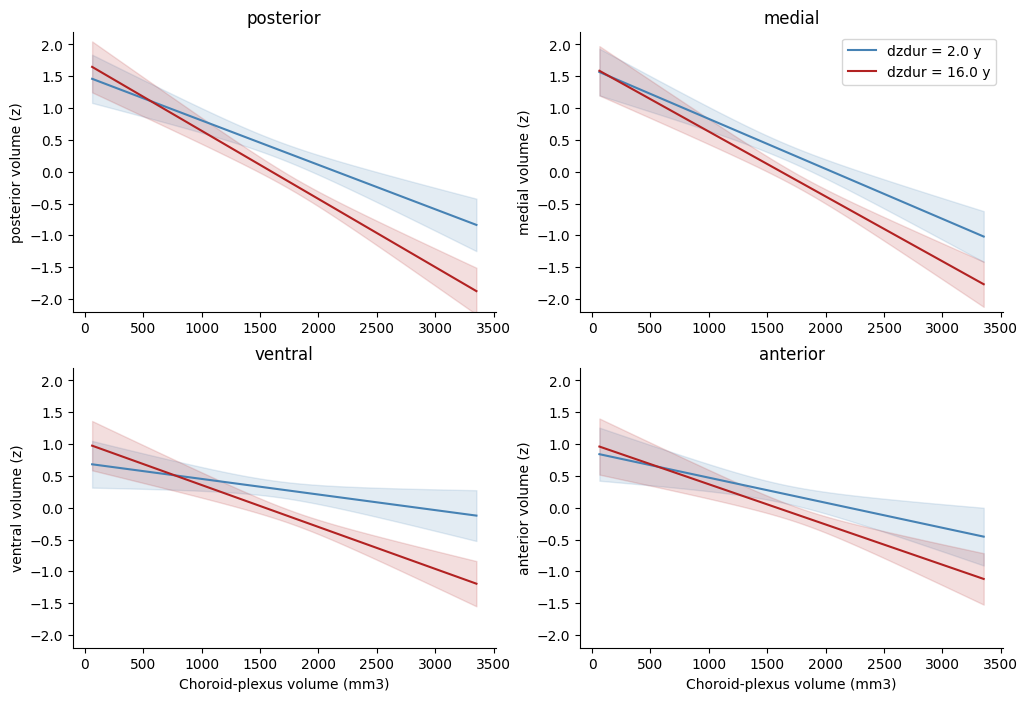

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplot_mosaic(
    [["posterior", "medial"], ["ventral", "anterior"]], figsize=(12, 8)
)

for struct in structs:
    ax = axes[struct]
    for dz, colour in zip(dzdur_levels, time_pt_colors):
        sub = test_data[np.abs(test_data["dzdur"] - dz) < 0.001]
        dzdur_label = scaler_dzdur.inverse_transform([[dz]]).flatten()[0]
        ax.plot(
            sub["cp_raw"],
            sub[f"{struct}_fit"],
            label=f"dzdur = {dzdur_label} y",
            color=colour,
        )
        ax.fill_between(
            sub["cp_raw"],
            sub[f"{struct}_lower"],
            sub[f"{struct}_upper"],
            color=colour,
            alpha=0.15,
        )
    sns.despine()
    ax.set_title(struct)
    ax.set_ylabel(f"{struct} volume (z)")
    ax.set_ybound([-2.2, 2.2])

axes['anterior'].set_xlabel("Choroid-plexus volume (mm3)")
axes['ventral'].set_xlabel("Choroid-plexus volume (mm3)")
axes['medial'].legend()

# plt.savefig(fig_path / "grouped_nuclei_cp_and_dzdur.png", dpi=300)

In [12]:
from marginaleffects import slopes, datagrid

model = models['posterior']
slopes(model, variables="choroid_volume", newdata=datagrid(dzdur=dzdur_levels))
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              posterior   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     41.41
Date:                Sun, 17 Aug 2025   Prob (F-statistic):           1.08e-49
Time:                        22:02:06   Log-Likelihood:                -536.92
No. Observations:                 468   AIC:                             1092.
Df Residuals:                     459   BIC:                             1129.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [ ]:
nucleus = "posterior"
model = models[nucleus]
# 1) Omnibus CP×spline test (per nucleus)
# names will look like 'choroid_volume:cr(dzdur, df=3)[0]' etc.
L = np.zeros((3, len(model.params)))  # 3 interaction rows
for i, tag in enumerate(["[0]", "[2]"]):
    col = model.params.index.get_loc(f"choroid_volume:cr(dzdur, df=3){tag}")
    L[i, col] = 1.0
wald = model.wald_test(L)
# wald.statistic, wald.df_denom, wald.pvalue
print(wald.pvalue)

# 3) Multiple testing control across nuclei
from statsmodels.stats.multitest import multipletests

pvals = np.array([wald_i.pvalue for wald_i in wald_list])  # one per nucleus
rej, qvals, *_ = multipletests(pvals, method="fdr_bh")

Check that three splines is a better model than simple interaction term

In [ ]:
from statsmodels.stats.anova import anova_lm

m_rcs = sm.OLS.from_formula(
    "THALAMUS_1 ~ choroid_volume * cr(dzdur, df=2, constraints='center')  + age + Female + tiv",
    data=model_data,
).fit()
m_lin = sm.OLS.from_formula(
    "THALAMUS_1 ~ choroid_volume * dzdur + age + Female + tiv", data=model_data
).fit()

lr_stat, lr_p, df_diff = m_rcs.compare_lr_test(m_lin)
print(anova_lm(m_lin, m_rcs, typ=1))
print("ΔAIC =", m_lin.aic - m_rcs.aic)
print("ΔBIC =", m_lin.bic - m_rcs.bic)

   df_resid         ssr  df_diff  ss_diff         F    Pr(>F)
0     461.0  249.593551      0.0      NaN       NaN       NaN
1     459.0  242.905451      2.0   6.6881  6.318997  0.001962
ΔAIC = 8.711591512347695
ΔBIC = 0.4146549205122483


In [19]:
m_rcs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             THALAMUS_1   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     54.89
Date:                Mon, 18 Aug 2025   Prob (F-statistic):           3.06e-62
Time:                        22:14:15   Log-Likelihood:                -510.61
No. Observations:                 468   AIC:                             1039.
Df Residuals:                     459   BIC:                             1077.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -0.1622      0.102     -1.597      0.111      -0.362       0.037
choroid_volume                             -0.0372      0.111     -0.337      0.736      -0.254       0.180
cr(dzdur, knots=[k1])[0]                    0.5780      0.099      5.813      0.000       0.383       0.773
cr(dzdur, knots=[k1])[1]                    0.1335      0.122      1.097      0.273      -0.106       0.373
cr(dzdur, knots=[k1])[2]                   -0.8737      0.289     -3.022      0.003      -1.442      -0.306
choroid_volume:cr(dzdur, knots=[k1])[0]    -0.1779      0.093     -1.914      0.056      -0.360       0.005
choroid_volume:cr(dzdur, knots=[k1])[1]    -0.4401      0.133     -3.303      0.001      -0.702      -0.178
choroid_volume:cr(dzdur, knots=[k1])[2]     0.5807      0.311      1.865      0.063      -0.031       1.193
age                                        -0.0287      0.044     -0.649      0.517      -0.116       0.058
Female                                      0.0909      0.041      2.225      0.027       0.011       0.171
tiv                                         0.5064      0.041     12.357      0.000       0.426       0.587
==============================================================================
Omnibus:                       47.667   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.776
Skew:                          -0.678   Prob(JB):                     5.79e-17
Kurtosis:                       4.412   Cond. No.                     2.13e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.43e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Suggestion from gpt was that if the linear model has a U type of shape, that's support for using a spline model. There's very vaguely a U shape

GPT said if spline lead to > 1-2% improvement, that's support for the spline model

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import numpy as np


def cv_rmse(model_formula):
    rmses = []
    for tr, te in KFold(n_splits=5, shuffle=True, random_state=1).split(model_data):
        m = smf.ols(model_formula, data=model_data.iloc[tr]).fit()
        y_hat = m.predict(model_data.iloc[te])
        rmses.append(
            np.sqrt(mean_squared_error(model_data.iloc[te]['THALAMUS_1'], y_hat))
        )
    return np.mean(rmses)


# rmse_lin  = cv_rmse("THALAMUS_1 ~ choroid_volume * dzdur + age + Female + tiv")
rmse_1 = cv_rmse("THALAMUS_1 ~ choroid_volume + dzdur + age + Female + tiv")
rmse_rcs = cv_rmse("THALAMUS_1 ~ choroid_volume * cr(dzdur, df=3) + age + Female + tiv")
# rmse_2  = cv_rmse("THALAMUS_1 ~ choroid_volume + age + Female + tiv")
print("CV-RMSE simple =", rmse_1, "  spline =", rmse_rcs)
(rmse_1 - rmse_rcs) / rmse_1

CV-RMSE simple = 0.7414884585515777   spline = 0.7369158706193059


np.float64(0.0061667688546413425)

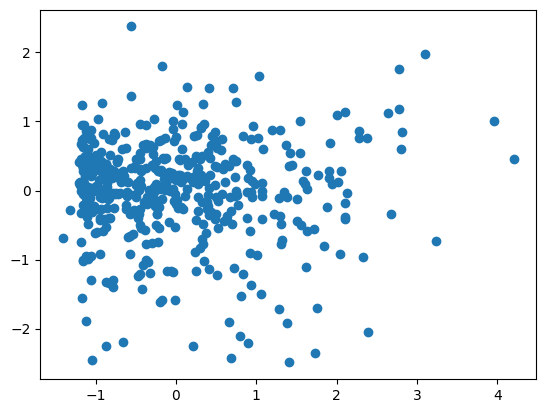

In [13]:
plt.scatter(model_data['dzdur'], m_lin.resid)

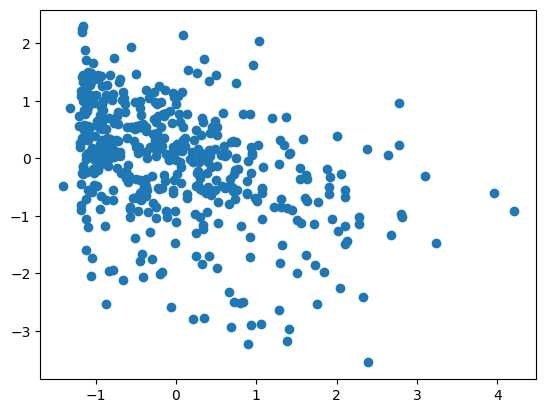

In [14]:
plt.scatter(model_data['dzdur'], model_data['THALAMUS_1'])

Intuition for spline basis functions

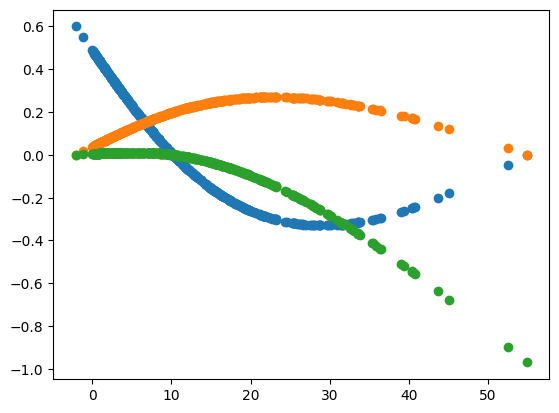

In [85]:
from patsy import dmatrix

y = dmatrix("cr(dzdur, df=3)", raw_data)
plt.scatter(raw_data['dzdur'], y[:, 1] * 0.6)
plt.scatter(raw_data['dzdur'], y[:, 2] * 0.2)
plt.scatter(raw_data['dzdur'], y[:, 3] * -0.97)

In [117]:
seg1, seg2, seg3 = np.array_split(raw_data['dzdur'].sort_values(), 3)

seg3

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


subid
1226    15.320594
2171    15.328807
2112    15.413678
1046    15.441056
1155    15.514976
          ...    
1475    40.751793
1469    43.686689
1471    45.118546
1176    52.458523
1370    54.886930
Name: dzdur, Length: 156, dtype: float64

## Scratch

In [ ]:
formula = (
    "THALAMUS_1 ~ choroid_volume + t2lv + PRL + cortical_thickness + age + Female + tiv"
)
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:             THALAMUS_1   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     126.2
Date:                Tue, 24 Jun 2025   Prob (F-statistic):          8.07e-103
Time:                        19:01:19   Log-Likelihood:                -416.95
No. Observations:                 468   AIC:                             849.9
Df Residuals:                     460   BIC:                             883.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0273      0

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[2.08961111]]), p=0.14898473329703613, df_denom=460, df_num=1>

In [ ]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])


outcome_model = sm.OLS.from_formula(
    "THALAMUS_1 ~ choroid_volume + PRL + age + tiv + Female", data=model_data
)
mediator_model = sm.GLM.from_formula(
    "PRL ~ choroid_volume + age + tiv + Female",
    data=model_data,
    family=sm.families.Poisson(),
)

mediator_model = sm.OLS.from_formula(
    "choroid_volume ~ PRL + age + tiv + Female", data=model_data
)

med = Mediation(outcome_model, mediator_model, "PRL", "choroid_volume").fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),-0.066477,-0.121985,-0.018344,0.008
ACME (treated),-0.066477,-0.121985,-0.018344,0.008
ADE (control),-0.214685,-0.278625,-0.148698,0.000
ADE (treated),-0.214685,-0.278625,-0.148698,0.000
Total effect,-0.281163,-0.362700,-0.200874,0.000
Prop. mediated (control),0.234503,0.078337,0.395356,0.008
Prop. mediated (treated),0.234503,0.078337,0.395356,0.008
ACME (average),-0.066477,-0.121985,-0.018344,0.008
ADE (average),-0.214685,-0.278625,-0.148698,0.000
Prop. mediated (average),0.234503,0.078337,0.395356,0.008
